In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import random

/Users/liumeicheng/opt/anaconda3/envs/symptom-umap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate 3d s-curve

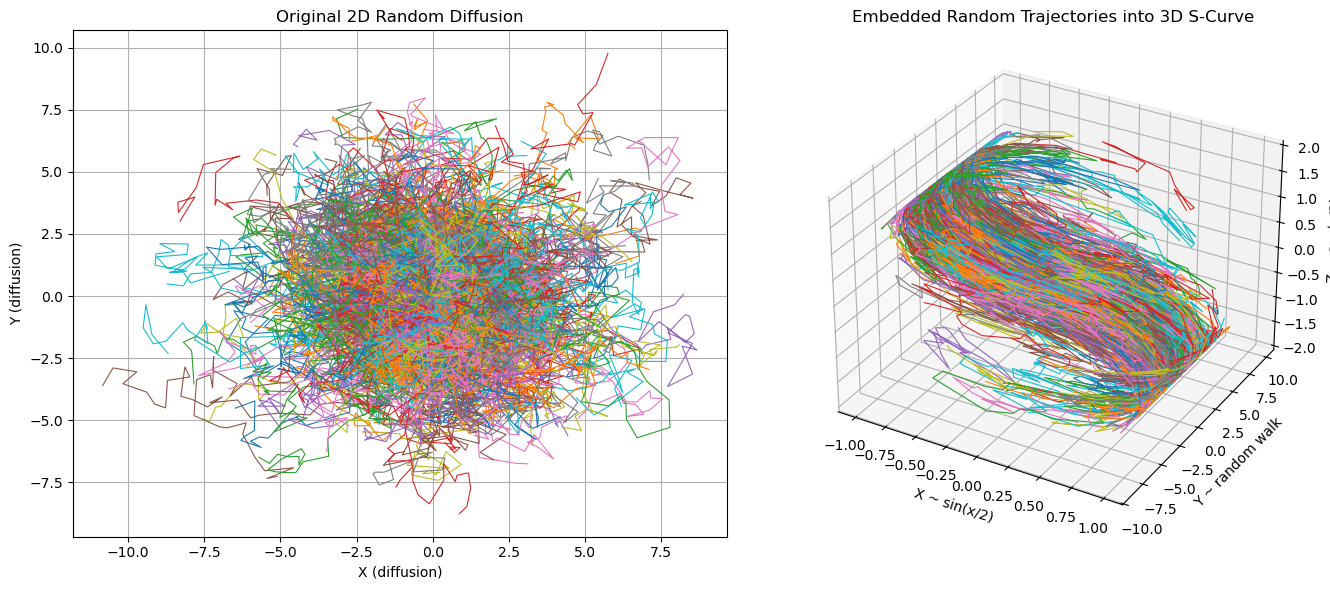

Generated data shape for embedding: (20000, 3)


In [2]:
#fix random seed for reproducibility
np.random.seed(42)

#parameters: number of trajectories, trajectory length, random step size
ntraj = 500        
trajlength = 40
sigma = 0.5

#generate 2d random diffusion trajectories
X = np.zeros((ntraj, trajlength, 2))
for i in range(ntraj):
    for j in range(1, trajlength):
        X[i, j] = X[i, j-1] + sigma * np.random.randn(2)

#map 2d diffusion to 3d
Z = np.zeros((ntraj, trajlength, 3))
for i in range(ntraj):
    for j in range(trajlength):
        x_val = X[i, j, 0]    # first dimension
        y_val = X[i, j, 1]    # second dimension
        Z[i, j, 0] = np.sin(x_val / 2)              
        Z[i, j, 1] = y_val                        
        Z[i, j, 2] = np.sign(x_val) * (np.cos(x_val / 2) - 1)  
        
#combine all points for later dimensionality reduction
all_points = Z.reshape(-1, 3)  # (ntraj*trajlength, 3)

#plot
fig = plt.figure(figsize=(14, 6))

#original 2d 
ax2d = fig.add_subplot(121)
for i in range(ntraj):
    ax2d.plot(X[i, :, 0], X[i, :, 1], linewidth=0.8)
ax2d.set_title("Original 2D Random Diffusion")
ax2d.set_xlabel("X (diffusion)")
ax2d.set_ylabel("Y (diffusion)")
ax2d.grid(True)

#embedded 3d
ax3d = fig.add_subplot(122, projection='3d')
for i in range(ntraj):
    ax3d.plot(Z[i, :, 0], Z[i, :, 1], Z[i, :, 2], linewidth=0.8)
ax3d.set_title("Embedded Random Trajectories into 3D S-Curve")
ax3d.set_xlabel("X ~ sin(x/2)")
ax3d.set_ylabel("Y ~ random walk")
ax3d.set_zlabel("Z ~ cos(x/2)")

plt.tight_layout()
plt.show()

print("Generated data shape for embedding:", all_points.shape)


# dimensionality reduction

/Users/liumeicheng/opt/anaconda3/envs/symptom-umap/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liumeicheng/opt/anaconda3/envs/symptom-umap/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


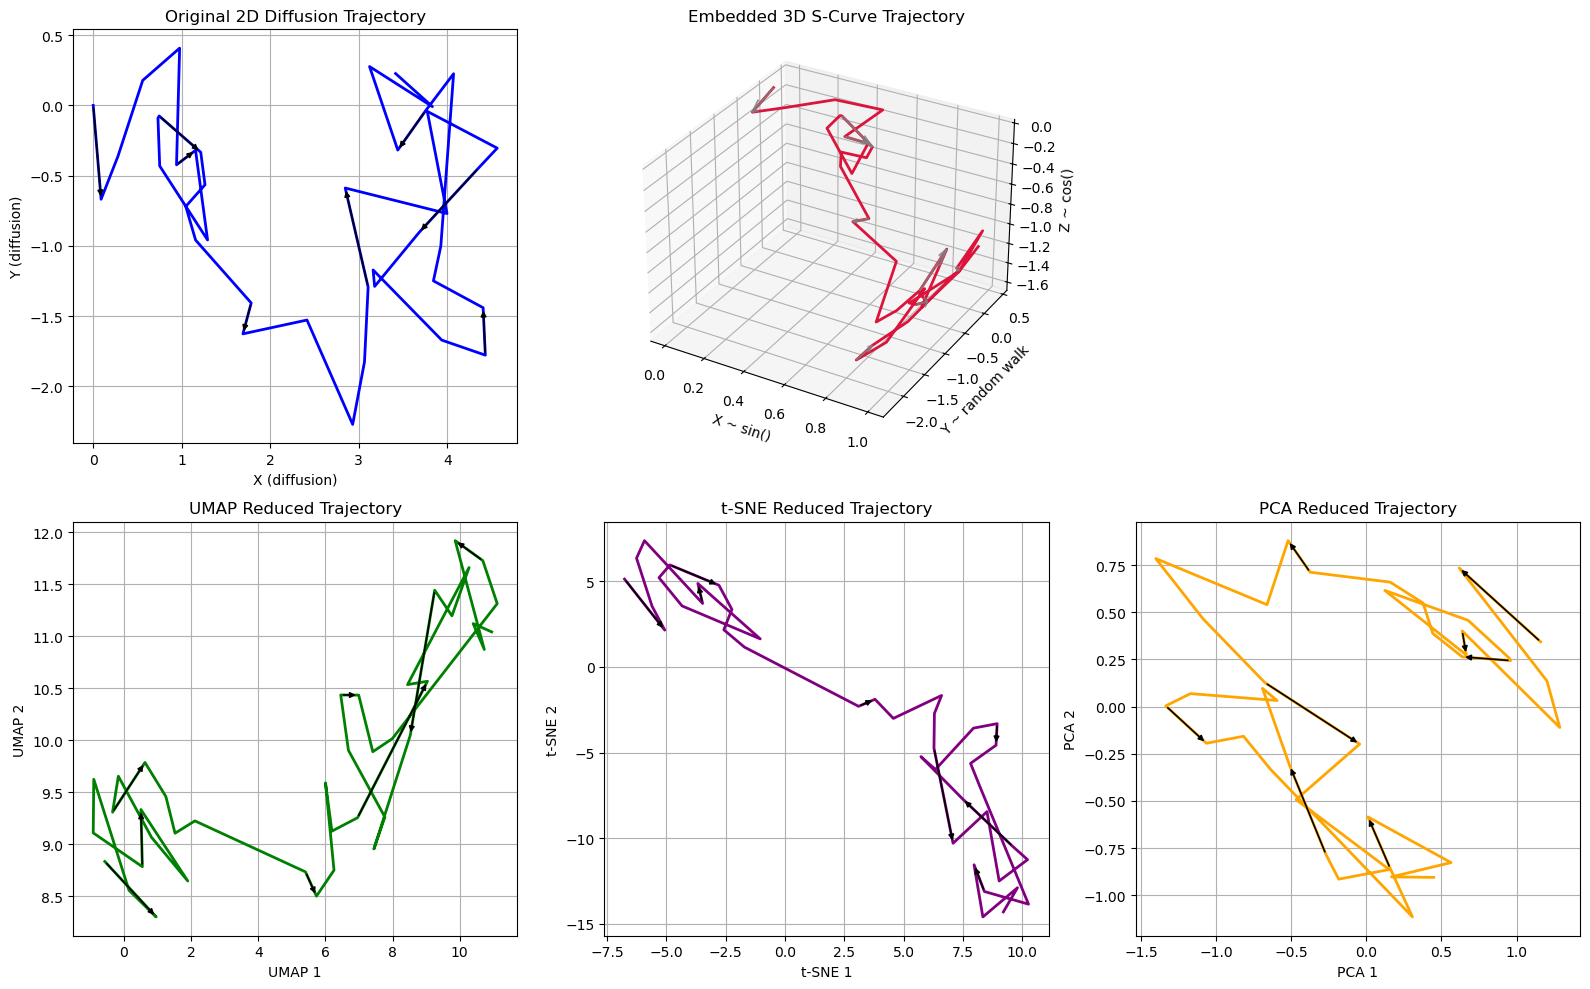

In [3]:
np.random.seed(42)

idx = 10
traj_2d = X[idx]   #original 2d
traj_3d = Z[idx]   #embedded 3d

#dimensionality reduction: UMAP PCA T-sne
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42)
traj_umap = umap_model.fit_transform(traj_3d)

tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
traj_tsne = tsne_model.fit_transform(traj_3d)

pca_model = PCA(n_components=2)
traj_pca = pca_model.fit_transform(traj_3d)

#plot
def plot_with_arrows(ax, traj, color, title, xlabel, ylabel):
    ax.plot(traj[:, 0], traj[:, 1], color=color, linewidth=2)
    for i in range(0, len(traj)-1, 5):  #draw an arrow every 5 points
        ax.annotate('', xy=traj[i+1], xytext=traj[i],
                    arrowprops=dict(arrowstyle='-|>', color='black', lw=1.2, mutation_scale=8))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)

fig = plt.figure(figsize=(16, 10))

#original 2d
ax1 = fig.add_subplot(2, 3, 1)
plot_with_arrows(ax1, traj_2d, 'blue',
                 "Original 2D Diffusion Trajectory",
                 "X (diffusion)", "Y (diffusion)")

#original embedded 3d
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.plot(traj_3d[:, 0], traj_3d[:, 1], traj_3d[:, 2], color='crimson', linewidth=2)
for i in range(0, len(traj_3d)-1, 5):
    start, end = traj_3d[i], traj_3d[i+1]
    vec = end - start
    ax2.quiver(*start, *vec, color='gray', arrow_length_ratio=0.3, alpha=0.8)
ax2.set_title("Embedded 3D S-Curve Trajectory")
ax2.set_xlabel("X ~ sin()")
ax2.set_ylabel("Y ~ random walk")
ax2.set_zlabel("Z ~ cos()")

#UMAP
ax3 = fig.add_subplot(2, 3, 4)
plot_with_arrows(ax3, traj_umap, 'green',
                 "UMAP Reduced Trajectory",
                 "UMAP 1", "UMAP 2")

#t-sne
ax4 = fig.add_subplot(2, 3, 5)
plot_with_arrows(ax4, traj_tsne, 'purple',
                 "t-SNE Reduced Trajectory",
                 "t-SNE 1", "t-SNE 2")

#PCA
ax5 = fig.add_subplot(2, 3, 6)
plot_with_arrows(ax5, traj_pca, 'orange',
                 "PCA Reduced Trajectory",
                 "PCA 1", "PCA 2")

plt.tight_layout()
plt.show()


# projection

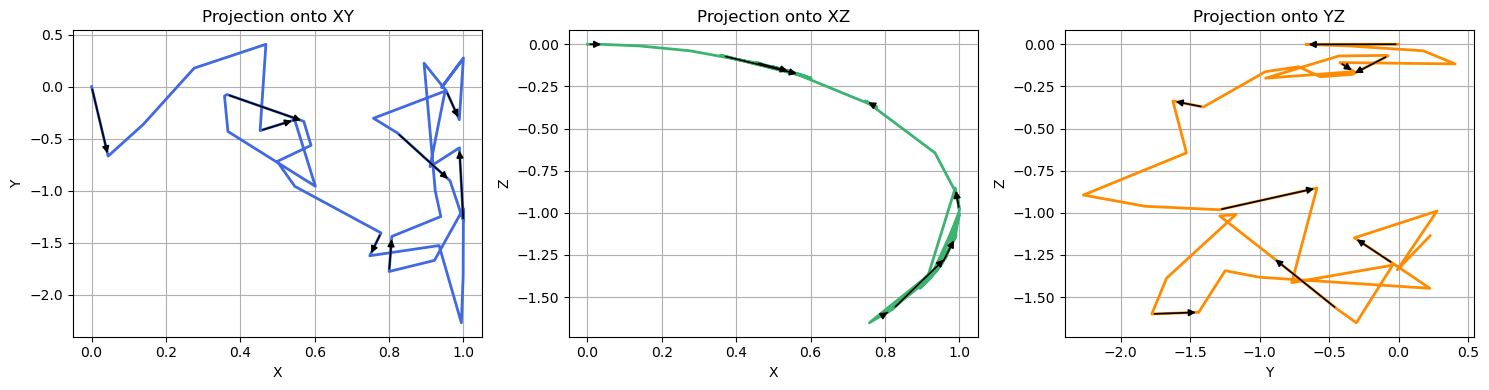

In [4]:
#projection：XY、XZ、YZ
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

#projection onto XY plane
axs[0].plot(traj_3d[:, 0], traj_3d[:, 1], color='royalblue', linewidth=2)
for i in range(0, len(traj_3d) - 1, 5):
    axs[0].annotate('', xy=traj_3d[i+1, :2], xytext=traj_3d[i, :2],
                    arrowprops=dict(arrowstyle='-|>', color='black', lw=1.2, mutation_scale=10))
axs[0].set_title("Projection onto XY")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].grid(True)

#projection onto XZ plane
axs[1].plot(traj_3d[:, 0], traj_3d[:, 2], color='mediumseagreen', linewidth=2)
for i in range(0, len(traj_3d) - 1, 5):
    axs[1].annotate('', xy=(traj_3d[i+1, 0], traj_3d[i+1, 2]),
                    xytext=(traj_3d[i, 0], traj_3d[i, 2]),
                    arrowprops=dict(arrowstyle='-|>', color='black', lw=1.2, mutation_scale=10))
axs[1].set_title("Projection onto XZ")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Z")
axs[1].grid(True)

#projection onto YZ plane
axs[2].plot(traj_3d[:, 1], traj_3d[:, 2], color='darkorange', linewidth=2)
for i in range(0, len(traj_3d) - 1, 5):
    axs[2].annotate('', xy=(traj_3d[i+1, 1], traj_3d[i+1, 2]),
                    xytext=(traj_3d[i, 1], traj_3d[i, 2]),
                    arrowprops=dict(arrowstyle='-|>', color='black', lw=1.2, mutation_scale=10))
axs[2].set_title("Projection onto YZ")
axs[2].set_xlabel("Y")
axs[2].set_ylabel("Z")
axs[2].grid(True)

plt.tight_layout()
plt.show()
